[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Khosraw/Science-Fair-2021---Predicting-Human-Behavior-Using-Deep-Learning-Market-Prediction/blob/main/SF_TF_BTC_Final.ipynb)

Saving to: tensorflow_hub/model_15/20211202-040754
Epoch 1/100
165/165 [==============================] - 28s 166ms/step - loss: 3079.5735 - mae: 3079.5737 - val_loss: 553.7625 - val_mae: 553.7625
Epoch 2/100
165/165 [==============================] - 28s 171ms/step - loss: 20.1705 - mae: 20.1705 - val_loss: 53.8681 - val_mae: 53.8681
Epoch 3/100
165/165 [==============================] - 28s 171ms/step - loss: 12.9398 - mae: 12.9398 - val_loss: 47.6101 - val_mae: 47.6101
Epoch 4/100
165/165 [==============================] - 28s 168ms/step - loss: 11.3957 - mae: 11.3957 - val_loss: 42.1537 - val_mae: 42.1537
Epoch 5/100
165/165 [==============================] - 27s 164ms/step - loss: 10.5546 - mae: 10.5546 - val_loss: 39.8814 - val_mae: 39.8814
Epoch 6/100
165/165 [==============================] - 27s 165ms/step - loss: 10.0772 - mae: 10.0772 - val_loss: 38.0957 - val_mae: 38.0957
Epoch 7/100
165/165 [==============================] - 28s 171ms/step - loss: 9.7201 - mae: 9.7201 - va

Text(0.5, 0, 'epochs')

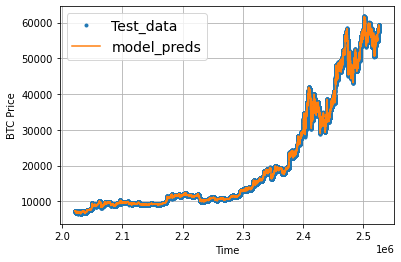

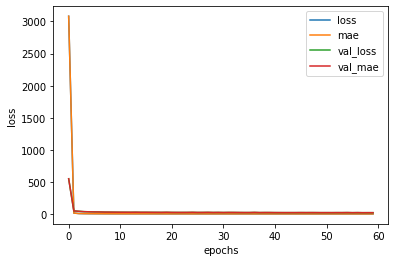

In [3]:
# model 16 - final
import datetime
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
import os

HORIZON = 1
WINDOW_SIZE = 30

# creating tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving to: {log_dir}")
  return tensorboard_callback

# label windows into X values and y values
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

# create a set of all windows and labels
def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 

  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split)) 
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

# ModelCheckpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, 
                                            save_best_only=True)

# plot the testing labels specific to the time-series problem
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

#################################################

np.set_printoptions(precision=15, suppress=True)
btc_data = pd.read_csv(
    "/content/output.csv",
    names=["Time", "Open", "Tone"])

ct = make_column_transformer(
    (MinMaxScaler(), ["Time"])
)

X_btc = btc_data[["Time", "Tone"]]
y_btc = btc_data["Open"]

ct.fit(X_btc, y_btc)
X_btc = ct.transform(X_btc)

timesteps = btc_data.index.to_numpy()
prices = btc_data["Open"].to_numpy()

split_size = int(0.8 * len(prices))
# Create train data splits (everything before the split)
X_train_a, y_train_a = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test_a, y_test_a = timesteps[split_size:], prices[split_size:]

# create the windows
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# split all the data
X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

# simple dense model architecture
btc_model_16 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_15")

btc_model_16.compile(loss = "mae",
                    optimizer = tf.optimizers.Adam(learning_rate=0.00002),
                    metrics=["mae"])

history = btc_model_16.fit(x=X_train, y=y_train, 
                          batch_size=12288, 
                          validation_data=(X_test, y_test),
                          epochs=100, 
                          callbacks=[early_stopping, create_model_checkpoint(model_name=btc_model_16.name), create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name=btc_model_16.name)])

# evaluate and predict
btc_model_16.evaluate(X_test, y_test, batch_size=8192)
y_pred = btc_model_16.predict(X_test)

btc_model_16.save("btc_model_16")
btc_model_16.save("btc_model_16.h5")

offset=0
plot_time_series(timesteps=X_test_a[-len(X_test):], values=y_test[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test_a[-len(X_test):], values=y_pred, start=offset, format="-", label="model_preds")

# plot loss curve
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

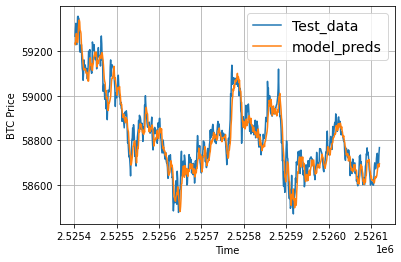

In [4]:
offset=504500
plot_time_series(timesteps=X_test_a[-len(X_test):], values=y_test[:, 0], start=offset, format="-", label="Test_data")
plot_time_series(timesteps=X_test_a[-len(X_test):], values=y_pred, start=offset, format="-", label="model_preds")

In [5]:
btc_data_predictions = pd.DataFrame()

X = X_test[:, 0]

btc_data_predictions["Open Price ($)"] = X

btc_data_predictions["Prediction Price ($)"] = y_pred

btc_data_predictions

,Open Price ($),Prediction Price ($)
0,7357.67,7356.800781
1,7358.20,7356.249512
2,7363.00,7354.166016
3,7365.81,7351.525879
4,7352.83,7353.129883
...,...,...
505214,58633.33,58683.378906
505215,58683.81,58693.320312
505216,58693.53,58684.085938
505217,58739.57,58681.816406


In [6]:
btc_data_predictions.to_csv("Bitcoin Data Predictions.csv", index=False)